### Regression Exercise 
# Moneyball The NBA
---

# Rough Guide a v1 model.
0. Make a model to predict PTS 
0. For v1, dont use `2P, 3P, FG, or FT`.  Instead use `2PA, 3PA, FTA`.  
0. Include any other cols use see fit.  


In [256]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot

import CTPLIB as ctp

In [257]:
df = pd.read_csv('data/NBA_train.csv')
df.dropna(inplace=True)

Text(0.5, 1.0, 'Probability of playoffs given wins')

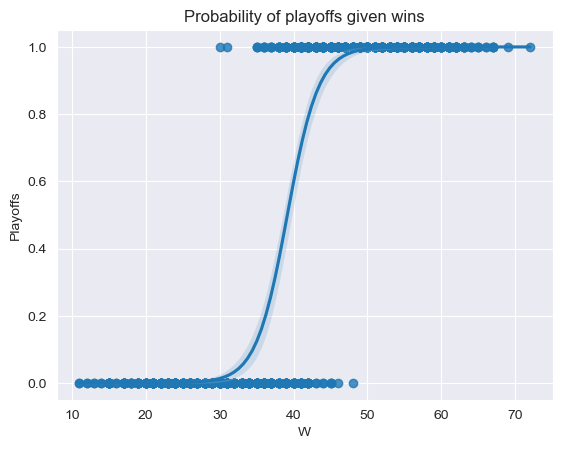

In [258]:
sns.regplot(data=df, x='W', y='Playoffs', logistic=True)
plt.title('Probability of playoffs given wins')

Let Y represent the event of a team making the playoffs. The expression P(Y | W) represents the likelihood a team making the playoffs given W wins.

The bottom and top horizontal lines represent:
- Teams that did not make the playoffs P(Y | W) = 0
- Teams that did make the playoffs P(Y | W) = 1

The logistic regression curve shows that the playoff probability increases exponentially at P(Y | W >= 30) and reaches near certainty at P(Y | W >= 50).
___

To model P(Y | W) we first need to predict the number of Wins. Let's start by filtering out noisy columns (ie. dates and team names) that do not contribute to teams winning.

Additionally, target columns (ie. points, playoffs) must be filtered out, as they indicate a team's performance rather than the underlying factors that drive it.

Text(0.5, 1.0, 'Correlation matrix')

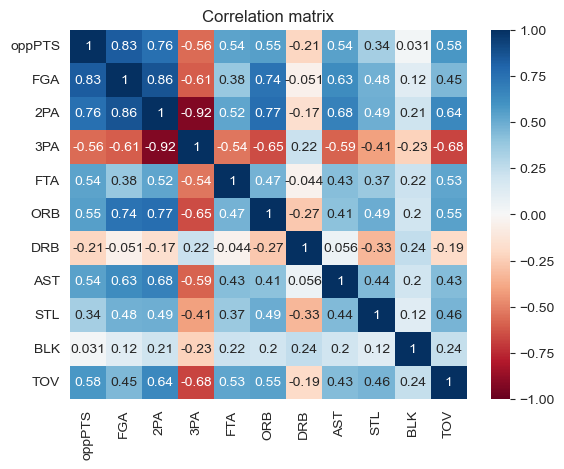

In [259]:
y = df['W'] # target variable, we want to predict Wins
columns_to_drop = ['PTS', '2P', '3P', 'FG', 'FT', 'SeasonEnd', 'Team', 'Playoffs', 'W']
X = df.drop(columns=columns_to_drop)

correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, cmap='RdBu', vmin=-1, vmax=1, annot=True)
plt.title('Correlation matrix')

Column definitions:

- oppPTS: Opponent points (points allowed by the team)
- FGA, 2PA, 3PA, FTA: Field goals attempted, two-point attempts, three-point attempts, free throw attempts
- ORB, DRB: Offensive rebounds, Defensive rebounds
- AST, STL, BLK, TOV: Assists, Steals, Blocks, Turnovers

Multicollinearity, or multiple independent variables being highly related is bad for regression analysis. This is because each additional variable reduces the degrees of freedom regression analysis has, which leads to overfitting. Degrees of freedom (df) is calculated by:

df = n - k - 1, where n = |observations|, let k = |independent variables|

From the correlation matrix, we can see that a number of variables are closely related. Namely:
- FGA and 2PA: Both measure field goals attempted. We'll drop 2PA as FGA is a more generalized measure.
- FGA and oppPTS: We'll drop oppPTS because it is not something our team has control over. It also has high correlation with FGA.
---

Next up, we will seek to further reduce independent variables by filtering out variables with low standard deviation. If they do not vary much, it's likely they only serve to reduce the degrees of freedom as opposed to contributing predictive power.

Text(0.5, 1.0, 'Standard deviation of each feature')

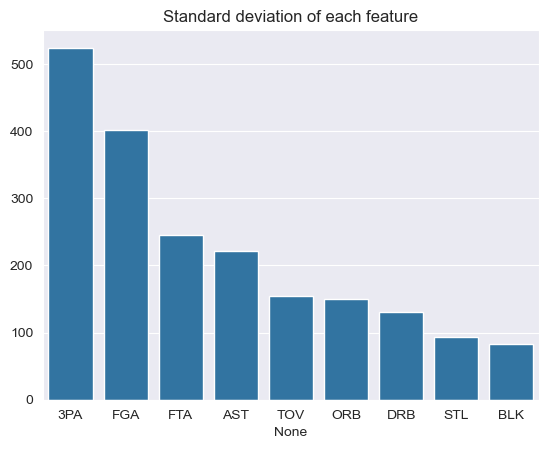

In [260]:
columns_to_drop = ['2PA', 'oppPTS']
X.drop(columns=columns_to_drop, inplace=True)

sd = X.std()
sd = sd.sort_values(ascending=False)
sns.barplot(x=sd.index, y=sd.values)
plt.title('Standard deviation of each feature')

In [261]:
columns_to_drop = ['STL', 'BLK']
X.drop(columns=columns_to_drop, inplace=True)

By now we have streamlined the dataset by dropping less informative columns, thereby increasing our degrees of freedom. In future projects, it would be ideal to use quantifiable methods for this process, as opposed to eyeballing it, but I digress.

In [262]:
display(X)

,FGA,3PA,FTA,ORB,DRB,AST,TOV
0,7027,75,2645,1369,2406,1913,1495
1,7387,422,2449,1227,2457,2198,1539
2,6943,275,2592,1115,2465,2152,1684
3,8041,187,2205,1307,2381,2108,1370
4,7470,255,2539,1311,2524,2079,1533
...,...,...,...,...,...,...,...
830,6979,1277,1981,1071,2526,1675,1324
831,6628,1727,1984,829,2603,1836,1101
832,6755,1091,1976,963,2343,1795,1206
833,6590,1256,2061,898,2338,1921,1175


At this point, I attempted to create and fit a linear regression model. However, I got the error "STOP: TOTAL NO. of ITERATIONS REACHED LIMIT."

It's worth noting that a regression consists of two parts:
- Sum of Squares due to Regression: The variance that can be explained by our regression model.
- Sum of Squares due to Error: The variance that cannot be explained by our regression model.

In linear regression, we repeatedly attempt drawing new linear lines to find which line minimizes SSE. This process is called "convergence." In this case, our model failed to find a suitable convergence within 500 iterations (500 attempts at drawing lines!). This might mean that our data might simply be unsuitable for linear regression. Or perhaps we might need to give more computational resources (more iteration attempts) to our model.

In this case, it turned out that the latter was the issue. However, increasing the number of iteration attempts is expensive, especially with larger sets of data. Instead, we can standardize it.

---

If you have ever taken a precalculus class, you likely learned that you can transform a function. For example, y=(x+2) means that x is delayed by 2 time units. Statisticians have expanded on this idea and created methods such as normalization and standardize, which makes the process of finding convergence less computationally expensive.

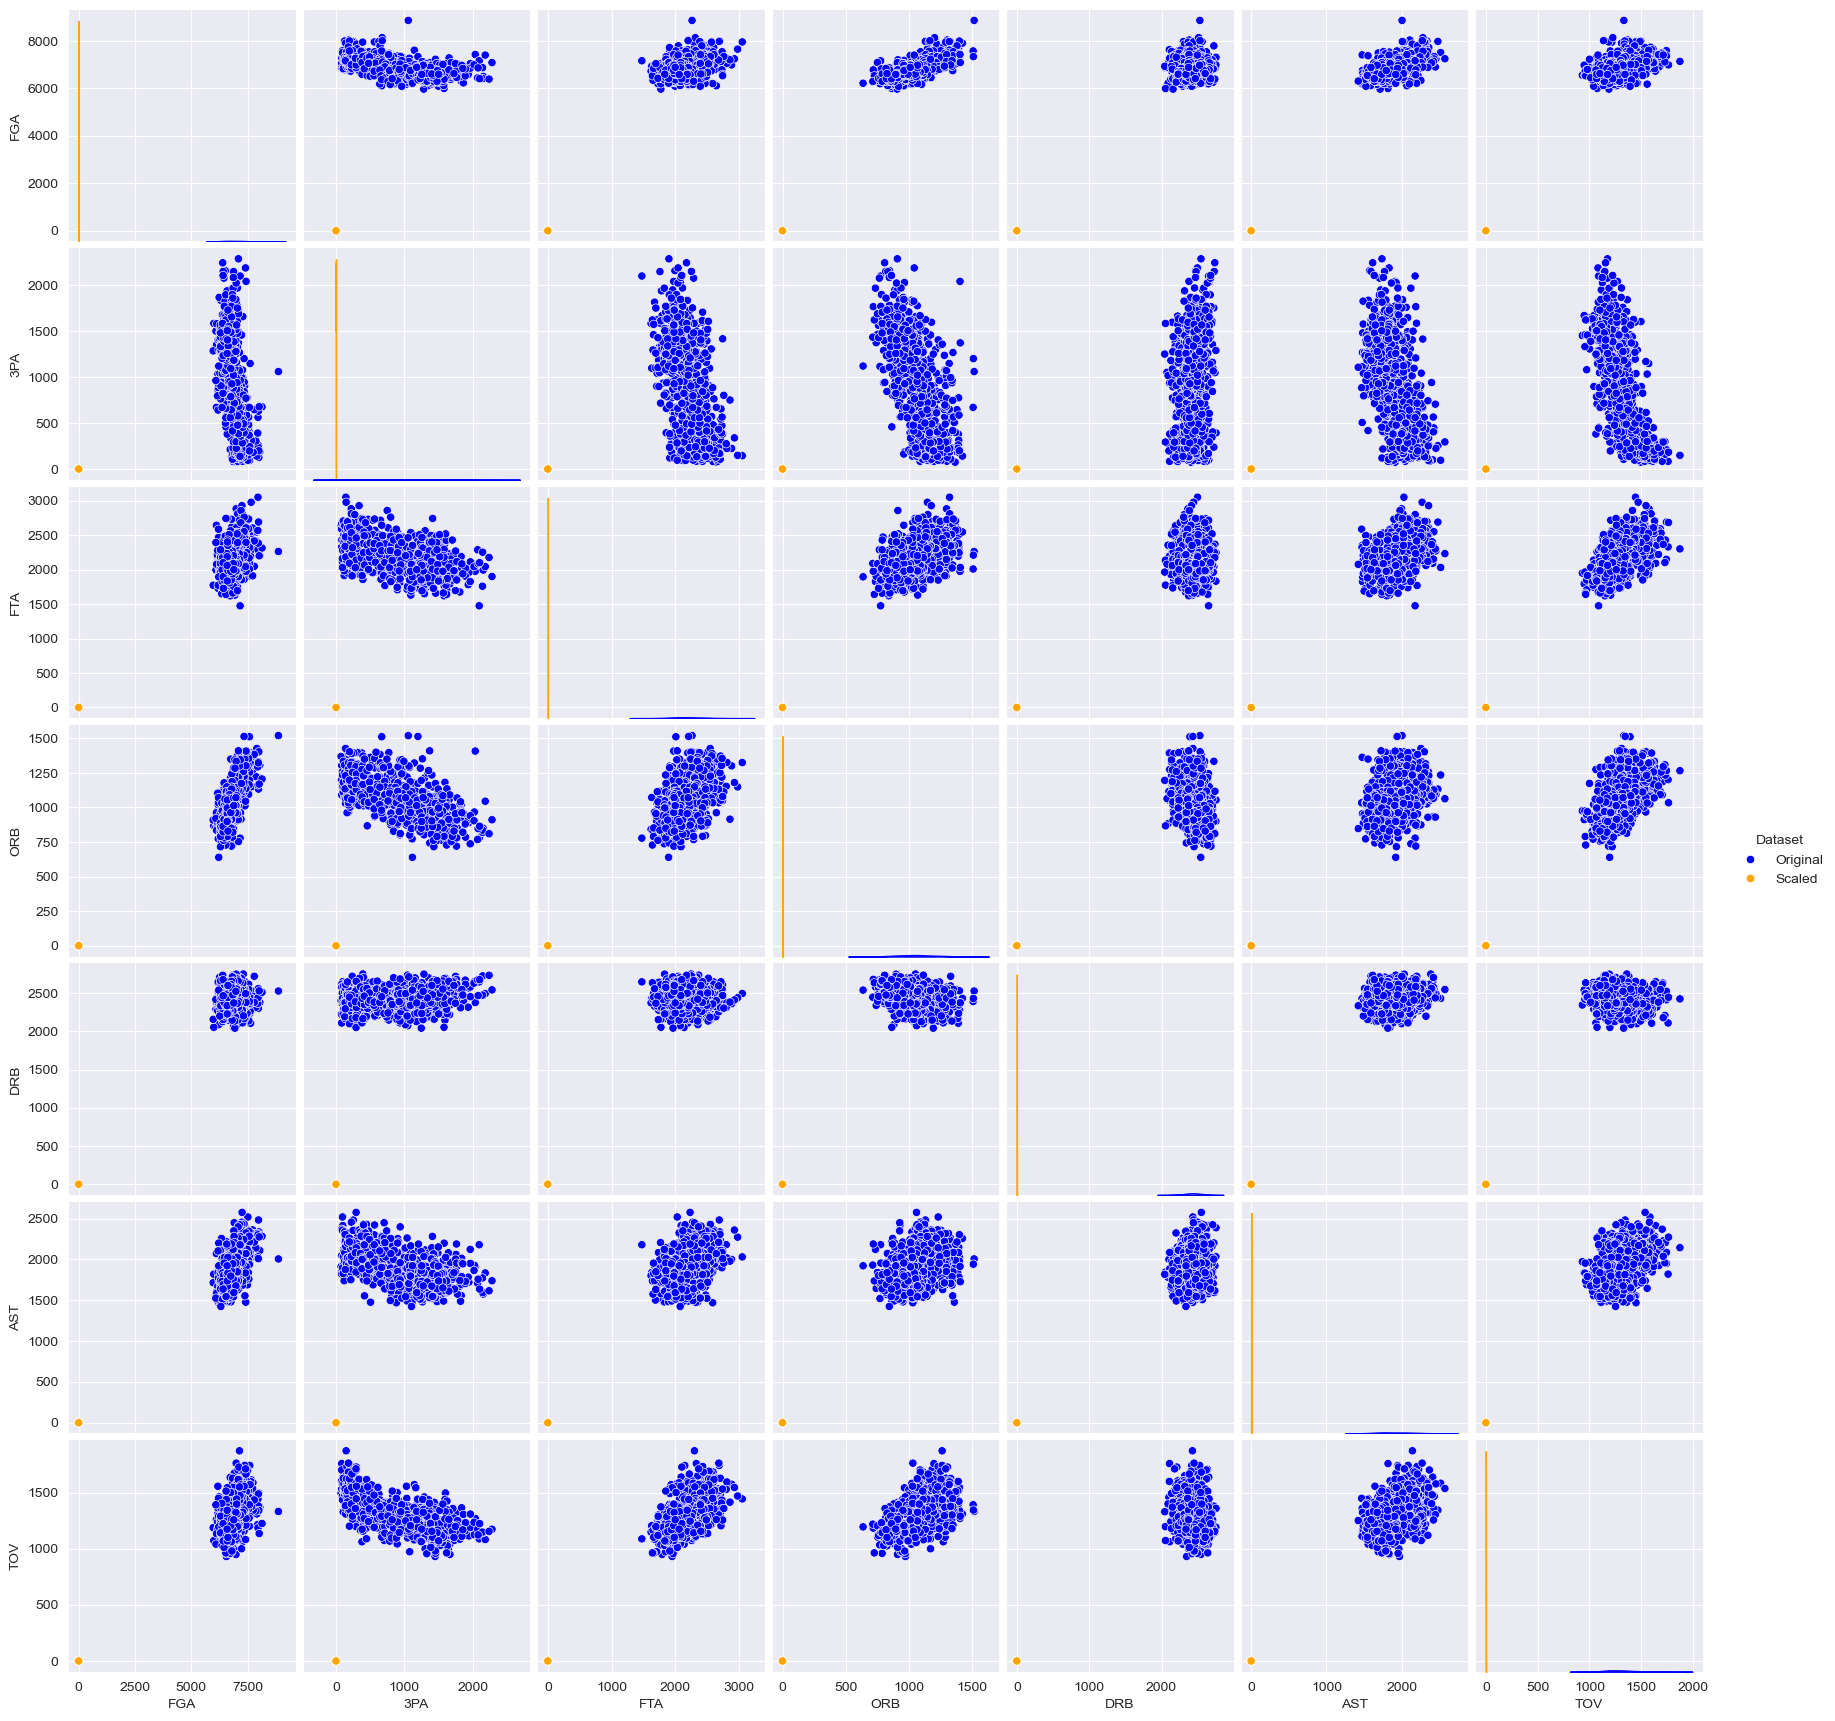

In [263]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X['Dataset'] = 'Original'
X_scaled['Dataset'] = 'Scaled'

X_combined = pd.concat([X, X_scaled])
sns.pairplot(X_combined, hue='Dataset', palette=['blue', 'orange'])

In [264]:


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# 
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# 
# Now fit the model on scaled data
# model = LogisticRegression(max_iter=500)
# model.fit(X_train, y_train)
